In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import *

from scipy.optimize import minimize


sys.path.append("../../modules")
# hand made functions
from Rouss import *

sys.path.append("../../Model_val/upscalling/")
from upscalling_functions import *

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "working"
model_name = "first_2D"
exe_name="../../exe/mf6"

In [3]:
MNT_path="../../data/surfaces_geoter_decoup/TOPO (inf 0 en mer).asc"
Agly_path= "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path= "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

In [4]:
top,BOT,idomain,delr,delc = read_pickle("working/export_dis")

In [17]:
thk = top-BOT
thk[thk==50]=None
thk[:,130:]=None

In [22]:
# volume total
0.2*np.nansum(thk*300*300)/1000/1000/1000

23.161384140800003

In [77]:
#spatial parameters
x0,x1,y0,y1 = Raster.load(MNT_path).bounds

ncol = idomain.shape[1]
nrow = idomain.shape[0]
nlay=1
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data
ix = GridIntersect(grid)

In [78]:
# Do a list of all active cells
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if idomain[irow,icol] == 1:
                lst_domain.append((ilay,irow,icol))
                
idomain = idomain.reshape(nrow*ncol)

In [79]:
# BC sea
# import the shapefile that correspond to the BC

BCsea_path = "../../data/shp/sea_bc_extended.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids(grid,BC_sea,idomain,type="polygon")

# attribute a constant head at all the cells in the lst_chd
CHD = 0.1; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [80]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.SHP"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids(grid,etangs.dissolve(by="NATURE"),idomain)

# attribute a constant head
elev = 0; et_lst=[];
for x in etangs_chd:
    et_lst.append((x,elev,1))

In [91]:
# recharge
rch_path="../../data/recharge/recharge_p.tif"
rcha = rspl_rast(rch_path,grid) # resample to grid
rcha[rcha<0]=np.mean(rcha[rcha>0]) # replace negative values by a mean

rcha[np.abs(idomain).sum(0)==0]=0 # remove rch in inactive cells
idomain = idomain.reshape(nrow,ncol)
rcha[idomain!=1]=0 # remove some rch
for cell in etangs_chd:
    rcha[cell[1],cell[2]]=0
for cell in lst_chd:
    rcha[cell[1],cell[2]]=0
    
rcha = liss_mob(rcha,5)# moving average

idomain = idomain.reshape(nrow*ncol)

In [ ]:
# BC Agly
Agy_chd = Complete_riv(Agly_path,"../../data/Fleuves/stations_agly.csv",us=28,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
# BC Tet
Tet_chd = Complete_riv(Tet_path,"../../data/Fleuves/stations_tet2.csv",us=180,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
#BC Boul
Bol_chd = Complete_riv(Bol_path,"../../data/Fleuves/stations_bol.csv",us=180,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
## BC Reart
Rea_chd = Complete_riv(Rea_path,"../../data/Fleuves/stations_reart.csv",us=130,ds=0,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
## BC Cant
Cant_chd = Complete_riv(Cant_path,"../../data/Fleuves/stations_cant.csv",us=135,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
# BC Tech
Tech_chd = Complete_riv(Tech_path,"../../data/Fleuves/stations_tech.csv",us=170,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

In [ ]:
#from chd to river
lst_riv_chd=[Agy_chd,Tech_chd,Cant_chd,Rea_chd,Tet_chd,Bol_chd]
cond = [0.005,0.005,0.005,0.005,0.005,0.005]

for iriv in range(len(lst_riv_chd)):
    chd2riv(lst_riv_chd[iriv],cond[iriv],2)

In [ ]:
# extraction
path = "../../data/prélèvements/donnees_sandra/SynthèseSLanini_data_Prelevements_1987-2018.shp"
V_col = "VOL_2013"
GDB = gp.read_file(path)
GDB = GDB[(GDB["USAGES"] != "IRRIGATION") & (GDB["geometry"] != None)]

layer = 0
stress_data_well = importWells(GDB,grid,lst_domain,V_col=V_col,layer=layer)

In [ ]:
# recharge irrig
irr_path = "../../data/recharge/rast_irr.asc"
irr = rspl_rast(irr_path,grid)
irr[irr<0]=0

#apply coefficient (btw 0.75 and 2)
coeff = 1
irr *= coeff

irr *= 1/1000/365/86400

In [ ]:
# prélèvements agricoles
path = "../../data/prélèvements/prlvm_agri.asc"
p_agri = rspl_rast(path,grid)

# make a list for rch package
p_agr=[]

for icell in lst_domain:
    irow = icell[1]
    icol = icell[2]
    if p_agri[irow,icol] != 0:
        p_agr.append(((icell),p_agri[irow,icol]/1000/365/86400))

In [ ]:
plt.imshow(p_agri)

In [24]:
# permeability

# initialize arrays that will define the position of the formations
idomainQ_rec = np.zeros([nrow*ncol])
idomainQ_a = np.zeros([nrow*ncol])
idomainPlio = np.zeros([nrow*ncol])

pathQr = "../../data/shp/entités/Alluv_rec.shp" # shapefile of the Quaternary formations
pathQa = "../../data/shp/entités/Alluv_anc.shp" #...
pathP = "../../data/shp/entités/Pliocene.shp"
lstIDQ_rec = gp2cellids(grid,gp.read_file(pathQr),idomainQ_rec,areas=10) #create the domains of each shp
lstIDQ_anc = gp2cellids(grid,gp.read_file(pathQa),idomainQ_a,areas=10) 
lstIDQPlio = gp2cellids(grid,gp.read_file(pathP),idomainPlio,areas=10)

In [25]:
# define k, different for each lithology
kh = 1e-5 # general k
kQr = 1.4e-4 # k for recent Quaternary
kQa = 1.1e-4 # k for ancient Quaternary
kp = 1.76e-5 # k for pliocene

k = np.ones([nrow*ncol])*kh # vector containing the permeability array(layer,nrow,ncol)
k[idomainPlio==1] = kp
k[idomainQ_rec==1] = kQr
k[idomainQ_a==1] = kQa

# store k in an external file
np.savetxt(os.path.join(model_dir,"k.txt"),k)

In [26]:
# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using this function (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
Control_pz = importControlPz(piez_path,grid,sheetName="2012",np_col="NP_Avril2013",x_col="x",y_col="y")

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [27]:
# Corbières
layer = 0
BDcells = cellidBD(idomain.reshape(nlay,nrow,ncol),layer)
poly = Polygon([(685e3,618.7e4),(685e3,619.5e4),(696e3,619.5e4),(696e3,618.7e4)])

Corb_spd = []
Corb_lst = []
flux = 0.2
res = ix.intersect_polygon(poly)
for cellid in res.cellids:
    cell = (layer,cellid[0],cellid[1])
    if cell in BDcells:
        Corb_lst.append(cell)
n_cells = len(Corb_lst)

for cell in Corb_lst:
    Corb_spd.append((cell,flux/n_cells))

In [28]:
## Thuir
layer = 0
poly = Polygon([(674e3,616.8e4),(674e3,617.4e4),(678e3,617.4e4),(678e3,616.8e4)])

plio_chd = []
for cellid in ix.intersect_polygon(poly).cellids:
    cell = (layer,cellid[0],cellid[1])
    if cell in BDcells:
        plio_chd.append((cell,120))

In [161]:
# basic modules

sim = fp.mf6.MFSimulation(sim_name='first2D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=BOT,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')


# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=BOT+1)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'ALL')])


# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=["k.txt"], save_flows=True,save_specific_discharge=True)

# recharge
rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = rcha/1000/365/86400,save_flows=True)
   
p_ag = fp.mf6.ModflowGwfrch(gwf,pname="p_ag",filename="p_ag.rch",stress_period_data={0 : p_agr},save_flows=True)

irr = fp.mf6.ModflowGwfrcha(gwf,pname="irr",filename="irr.rch",recharge=irr,save_flows=True)

# well package
wel = fp.mf6.ModflowGwfwel(gwf, pname="wel",filename="wel.wel",
                           stress_period_data=stress_data_well, maxbound=len(stress_data_well),save_flows=True)

#Corb
Corb = fp.mf6.ModflowGwfwel(gwf,pname="Corb",filename="Corb.wel",maxbound=len(Corb_spd),
                            stress_period_data=Corb_spd,save_flows=True)

#Thuir
thuir = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='thuir', filename="thuir.chd", maxbound=len(plio_chd), 
                                                       stress_period_data={0: plio_chd}, save_flows=True)

# constant heads packages
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

#rivers
etangs = fp.mf6.modflow.ModflowGwfdrn(gwf, pname='eta', filename="eta.drn", maxbound=len(et_lst), 
                                               stress_period_data={0: et_lst}, save_flows=True)

Riv1 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='agy', filename="agy.chd", maxbound=len(Agy_chd), 
                                              stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tet', filename="Tet.chd", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Rea', filename="Rea.chd", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Cant', filename="Cant.chd", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tech', filename="Tech.chd", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Bol', filename="Bol.chd", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)

In [162]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model first_2D...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha...
    writing package p_ag...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 3559 based on size of stress_period_data
    writing package irr...
    writing package wel...
    writing package corb...
    writing package thuir...
    writing package sea...
    writing package eta...
    writing package agy...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERS

(True, [])

In [163]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)
#spdis = get_spdis(model_name,model_dir)

# retrieve the chd package name
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

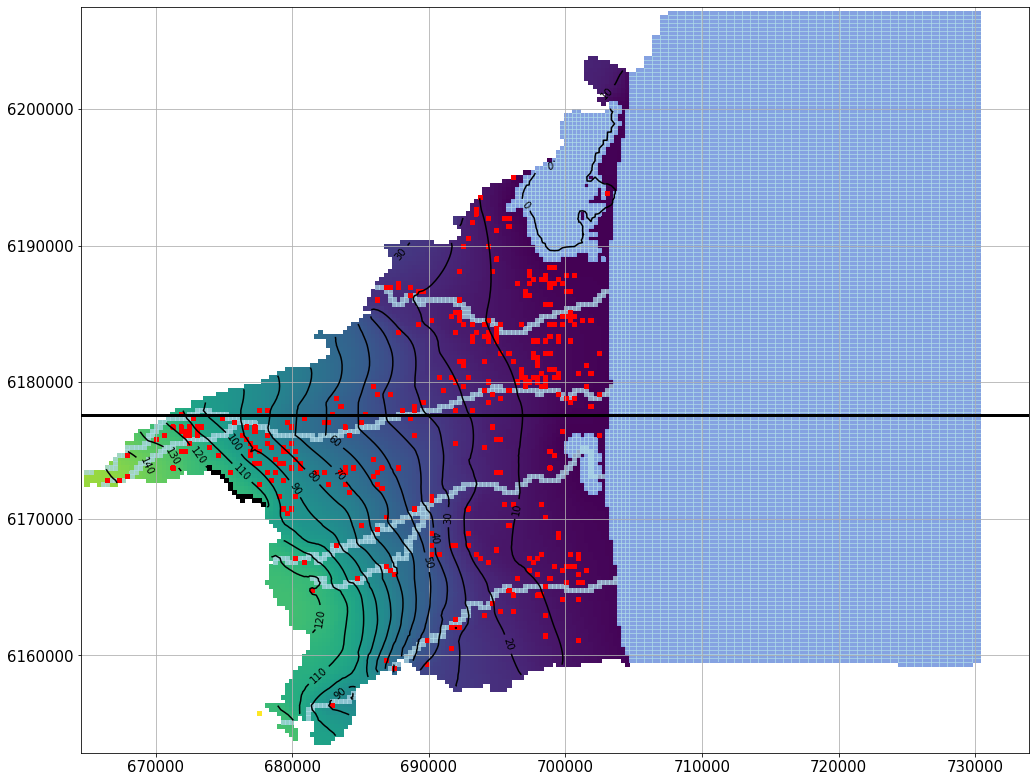

In [164]:
# make a plot
fig = plt.figure(figsize=(17,15))
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

hmesh=ml.plot_array(head,masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,180)
#ml.plot_specific_discharge(spdis[0],color="w",width=0.0050)
cont=ml.contour_array(head,masked_values=[0,1e30],levels=np.linspace(0,170,18),colors="k")
plt.clabel(cont,fmt="%1i")

# plot bc
for bc in bdfile:
    if bc == ("sea") or bc== ("eta"):
        ml.plot_bc(bc,color="b",alpha=0.5)
    if bc == ("thuir"):
        ml.plot_bc(bc,color="k")
    else : 
        ml.plot_bc(bc,color="lightblue",alpha=0.5)
ml.plot_bc("wel") # plot the wells  

# plot Cross-section
row = 100
x = [x0,x1]
y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
ax.plot(x,y,"k",linewidth=3)


ax.tick_params(labelsize=15)
#ax.tick_params(axis="y",direction="in", pad=-120)

ax.grid()

(-200, 300)

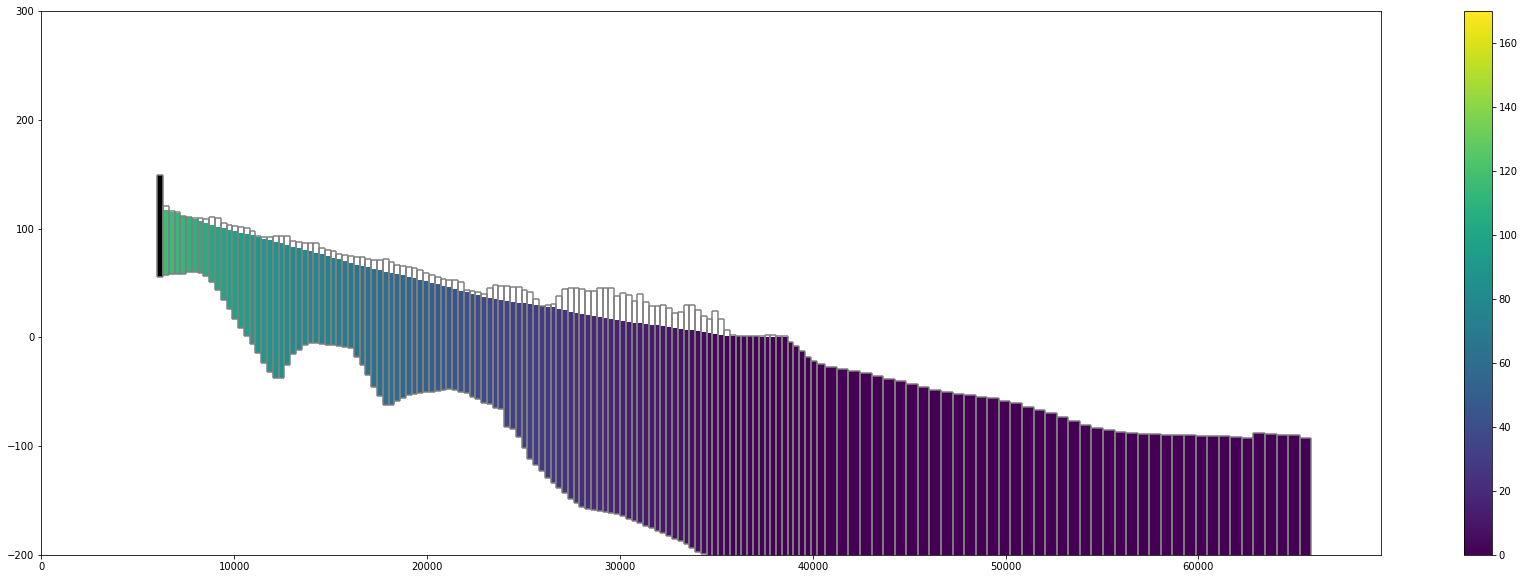

In [165]:
fig,ax = plt.subplots(figsize=(30,10))
x=fp.plot.PlotCrossSection(gwf,line={"row" :row})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid()
ax.set_ylim(-200,300)

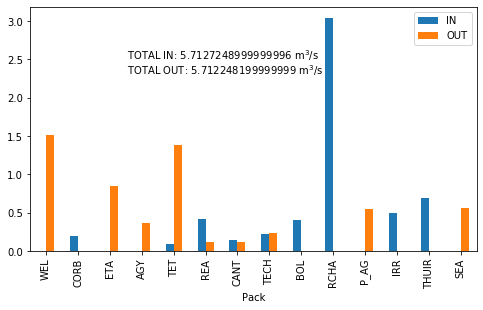

In [170]:
fig,ax = plt.subplots(figsize=(8,4.5))
Budget = get_Total_Budget(model_name,model_dir)
Budget.set_index("Pack").plot(kind="bar",ax=ax)
ax.text(2.55,2.5,"TOTAL IN: {} m$^3$/s".format(Budget.sum()["IN"]));
ax.text(2.55,2.3,"TOTAL OUT: {} m$^3$/s".format(Budget.sum()["OUT"]));

Text(0.5, 1.0, 'fit measured vs simulated')

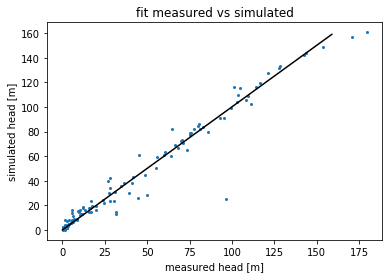

In [181]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)

head[head>1000]=None
plt.scatter(Control_pz[Control_pz!=0],
            head[0][Control_pz!=0],s=4)
plt.plot(np.arange(160),np.arange(160),"k")
plt.xlabel("measured head [m]")
plt.ylabel("simulated head [m]")
plt.title("fit measured vs simulated")

In [144]:
Misfit = np.abs((Control_pz[Control_pz!=0] - head[0][Control_pz!=0]))
print("Misfit : {} m ".format(np.nanmean(Misfit)))

Misfit : 4.613679834686151 m 


In [145]:
Misfit2 = (np.nansum((((Control_pz[Control_pz!=0] - head[0][Control_pz!=0])**2)/Control_pz[Control_pz!=0].shape[0])))**0.5
print("RMSE : {}".format(Misfit2))

RMSE : 9.158675593648063


In [212]:
phi = np.nansum((Control_pz[Control_pz!=0] - head[0][Control_pz!=0])**2)
print("phi : {}".format(phi))

phi : 9571.860903969588


In [148]:
def Misfit(kh):
    
    fp.mf6.mfpackage.MFPackage(gwf,package_type="npf").remove()# remove pre-existing npf package
    
    k = np.ones([nrow*ncol])*1e-5 # vector containing the permeability array(layer,nrow,ncol)
    k[idomainPlio==1] = kh[0]
    k[idomainQ_rec==1] = kh[1]
    k[idomainQ_a==1] = kh[2]
    
    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k) # create the new npf package
    npf.write() # write it
    if sim.run_simulation(silent = True): # And RUN !
        head = get_heads(model_name,model_dir)
        head[head>1000]=None
    
    return np.nanmean(np.abs((Control_pz[Control_pz!=0] - head[0][Control_pz!=0])))

In [171]:
# res = minimize(Misfit,(1.76e-5,1.4e-4,1.1e-4), method = 'Nelder-Mead')

In [172]:
res

 final_simplex: (array([[1.30250251e-05, 6.70758614e-05, 1.03632083e-04],
       [1.26364889e-05, 6.76734670e-05, 1.02643489e-04],
       [1.23408161e-05, 6.67569520e-05, 1.04398100e-04],
       [1.21482667e-05, 6.76178448e-05, 1.04862920e-04]]), array([4.53135134, 4.53138519, 4.53139285, 4.53144914]))
           fun: 4.531351340526708
       message: 'Optimization terminated successfully.'
          nfev: 86
           nit: 48
        status: 0
       success: True
             x: array([1.30250251e-05, 6.70758614e-05, 1.03632083e-04])